In [1]:
from dataset import DomainDataset
from torch.utils.data import DataLoader 
from model import DomainDistinguisher
import torch
from tqdm import tqdm
from FISHClass.utils.device import best_gpu
import numpy as np
import matplotlib.pyplot as plt
from FISHClass.utils.visualize import gridPlot

In [2]:
ds = DomainDataset("/home/simon_g/src/DomainAdapt/dm_set.h5")

In [3]:
dl = DataLoader(ds, shuffle=False, batch_size=256)

In [4]:
model = DomainDistinguisher(layers=[3, 16, 32, 64])

loss = torch.nn.MSELoss()

optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

device = best_gpu()
model.to(device)

for epoch in range(10):
    cumm_l = 0 
    with tqdm(dl) as train_loop:

        for X, y, i in train_loop:
            
            X = X.to(device)
            ret = model(X)
            
            optim.zero_grad()
            l = loss(X, ret)
            l.backward()
            optim.step()
            cumm_l += l.item()/X.shape[0]
            
            train_loop.set_postfix({"loss": cumm_l})

100%|██████████| 59/59 [00:16<00:00,  3.56it/s, loss=0.00117] 


In [5]:
device = best_gpu()
model.to(device)
model.eval()

orig, preds, ids = [], [], []
for X, y, i in tqdm(dl):
    orig.extend(X.numpy().transpose(0,2,3,1))
    X = X.to(device)
    preds.extend(model(X).detach().cpu().numpy())
    ids.extend(i)

100%|██████████| 59/59 [00:10<00:00,  5.80it/s]


In [6]:
preds = np.array(preds).transpose(0,2,3,1)
ids = np.array(ids)
orig = np.array(orig)

print(preds.shape, ids.shape)

(15000, 128, 128, 3) (15000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

15000


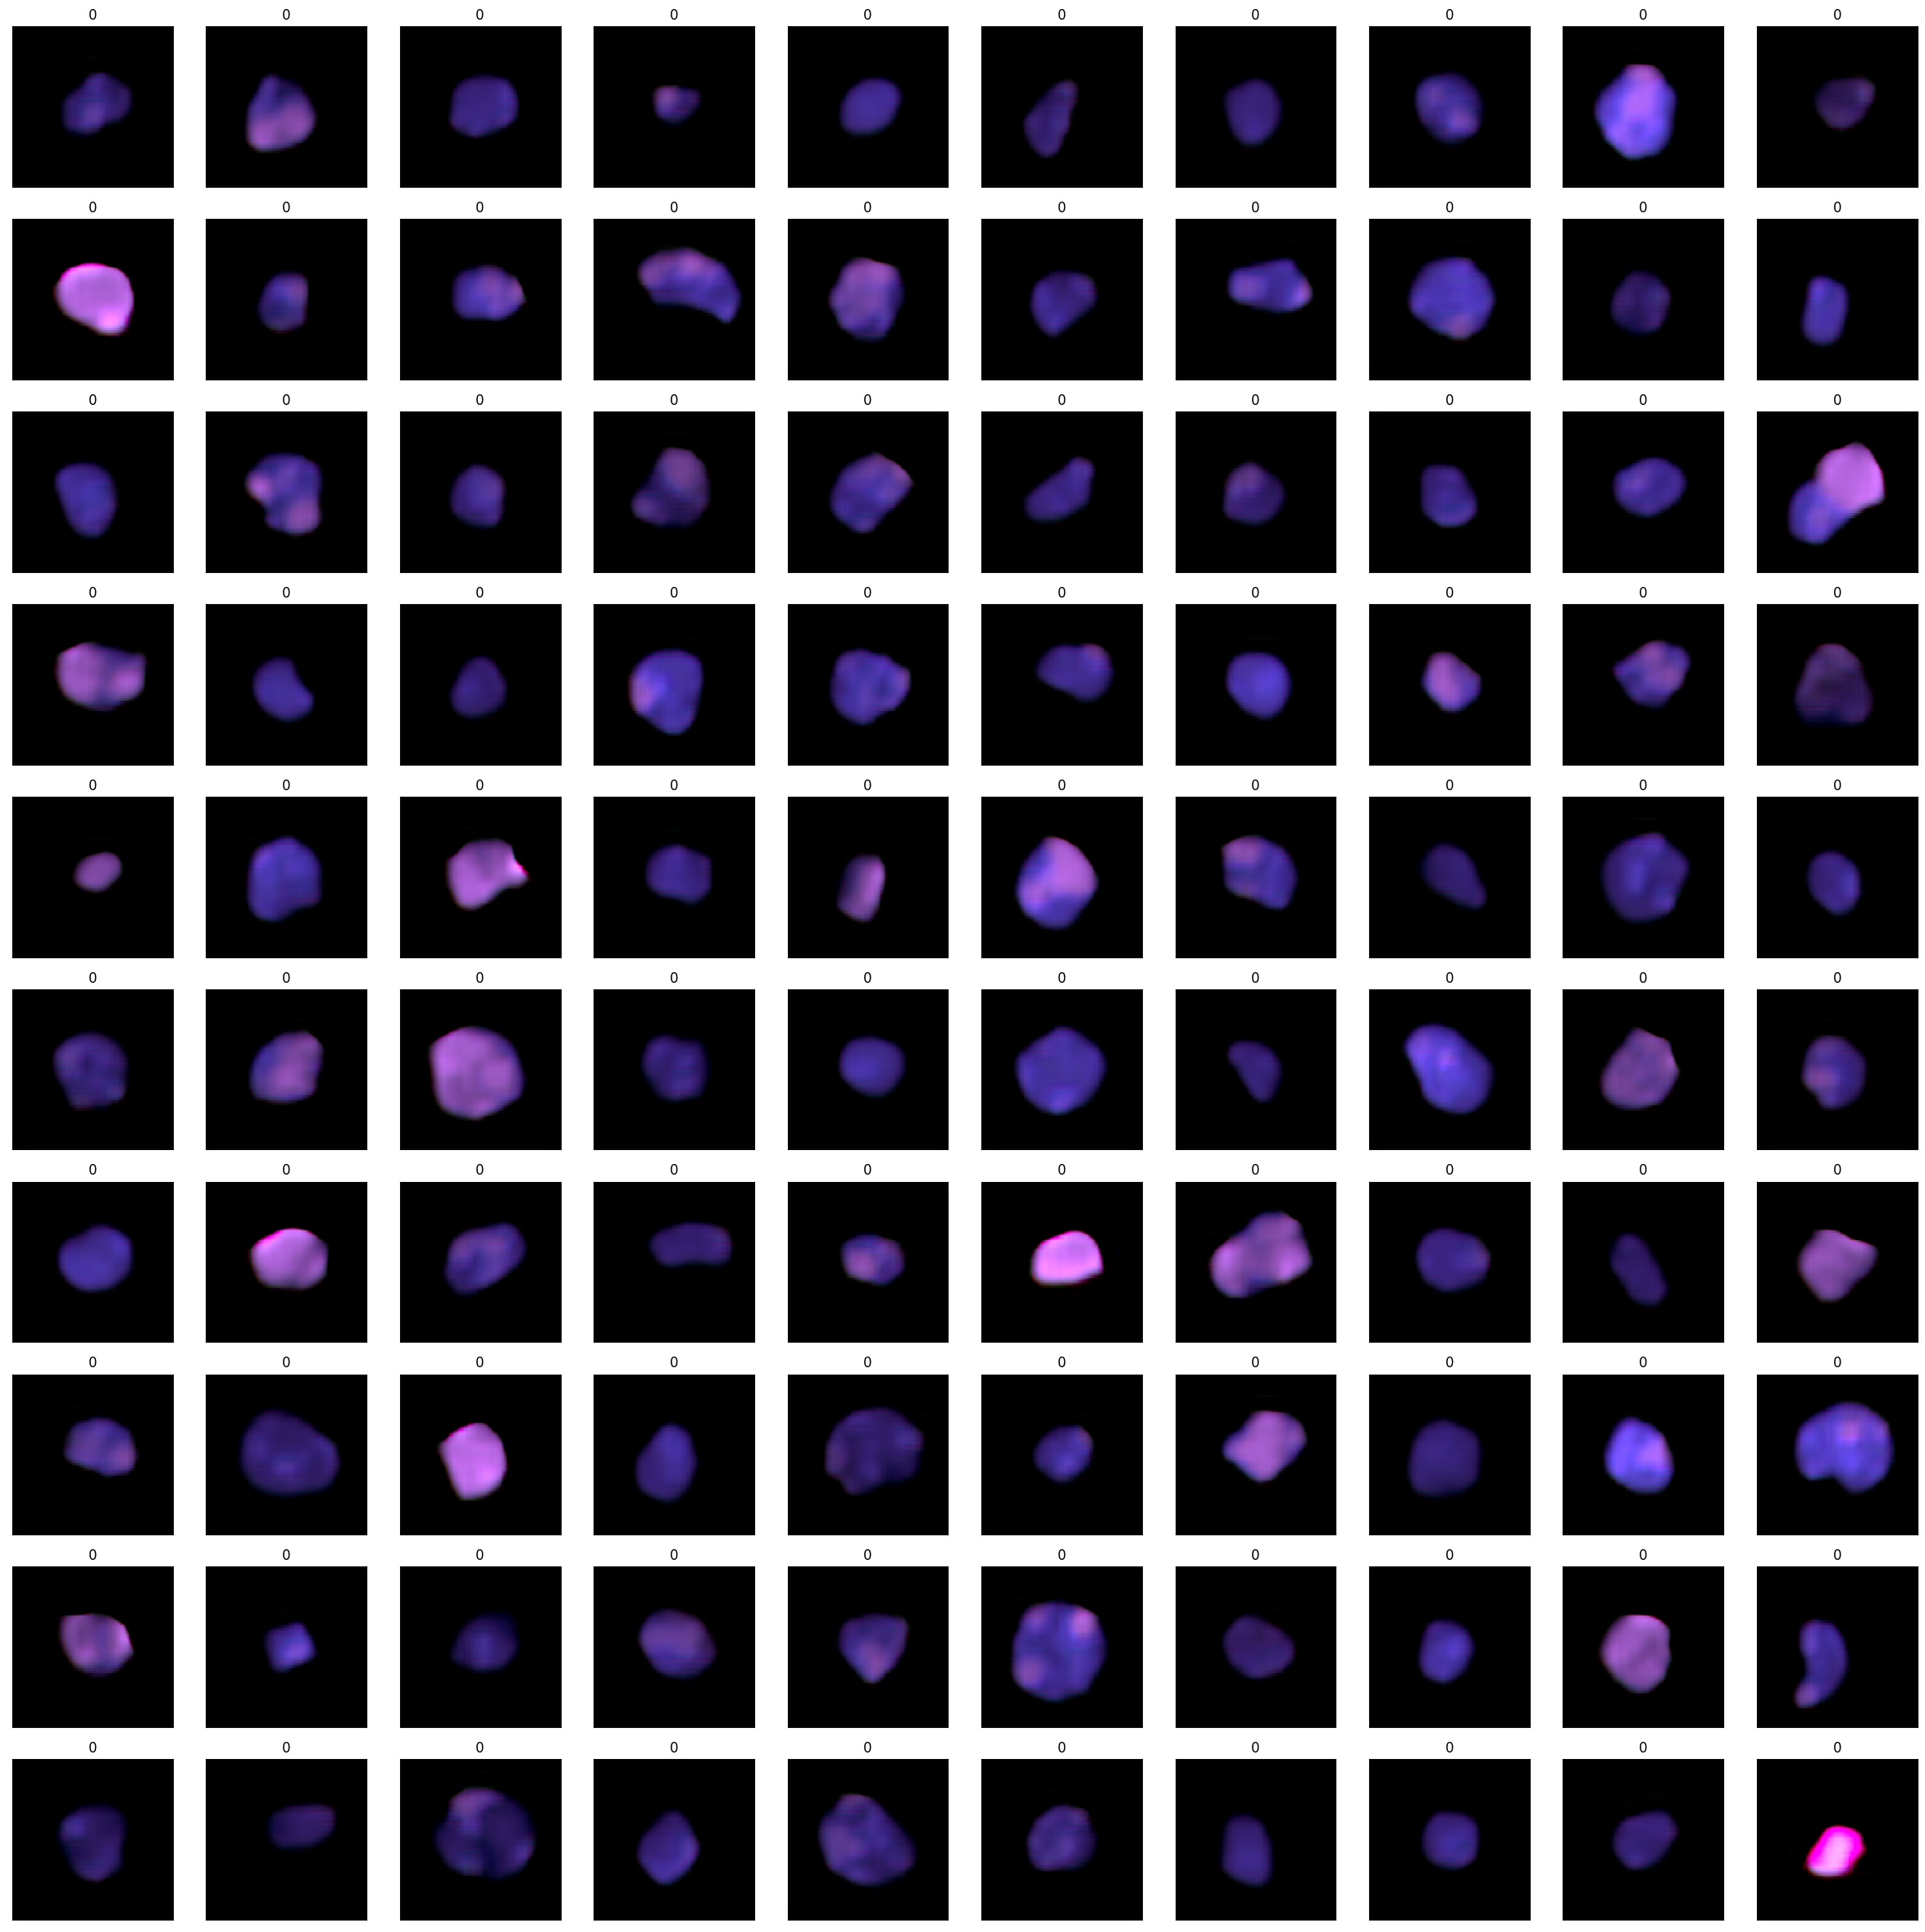

In [7]:
gridPlot(preds, ids)

In [8]:
fs = []
def get_info(self, input, output):
    
    fs.extend(output.detach().cpu().numpy().reshape(output.shape[0], -1))
    
hook = model.downs[-1].register_forward_hook(get_info)

In [9]:
device = best_gpu()
model.to(device)
model.eval()

orig, preds, ids, ys = [], [], [], []
for X, y, i in tqdm(dl):
    orig.extend(X.numpy().transpose(0,2,3,1))
    X = X.to(device)
    preds.extend(model(X).detach().cpu().numpy())
    ids.extend(i.numpy())
    ys.extend(y.numpy())

100%|██████████| 59/59 [00:10<00:00,  5.58it/s]


In [10]:
hook.remove()

In [11]:
fs = np.stack(fs, axis=0)
ids = np.array(ids)
ys = np.array(ys)

print(fs.shape)

(15000, 16384)


In [12]:
import pandas as pd
import numpy as np
import umap

mapper = umap.UMAP().fit(fs)
emb = mapper.transform(fs)

from umap.parametric_umap import ParametricUMAP

#mapper = ParametricUMAP().fit(fs)

2022-11-29 14:12:43.511876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/BB/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-29 14:12:43.511908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
#emb = mapper.transform(fs)

hover_data = pd.DataFrame({'index': np.arange(fs.shape[0]),
                           'label': ys,
                           'sample_id': ids,
                           'x': emb[:,0],
                           'y': emb[:,1]})

In [14]:
import umap.plot

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, hover_data=hover_data, point_size=5, labels=ids)
#p.star(test_pts[:,0], test_pts[:,1], size=20, color="black")
umap.plot.show(p)

Loading BokehJS ...

In [15]:
# inv_pts = mapper.inverse_transform(test_pts)

# X = torch.tensor(inv_pts.reshape(-1, 32, 8, 8)).to(device).double()

# for u in model.ups:
#     X = u(X)
    

# ims = X.detach().cpu().numpy().transpose(0,2,3,1)

# gridPlot(ims)

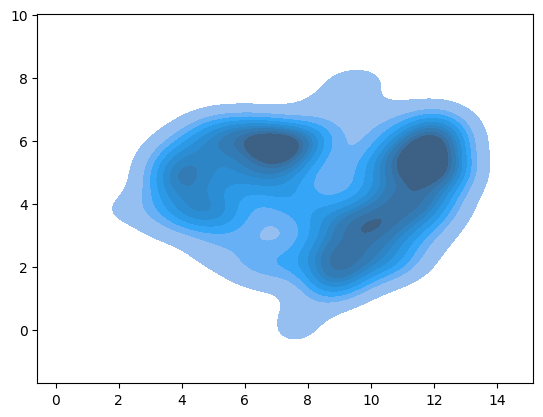

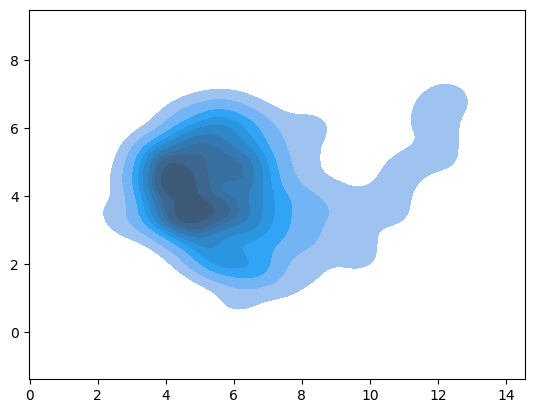

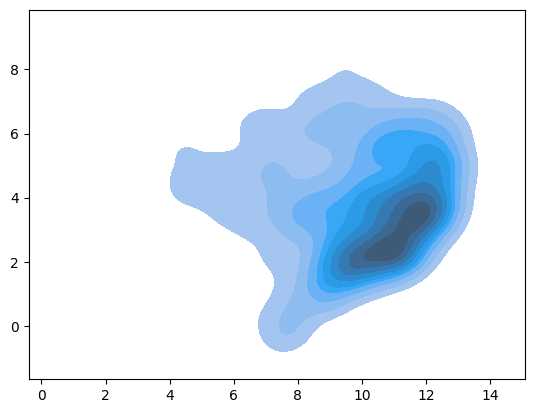

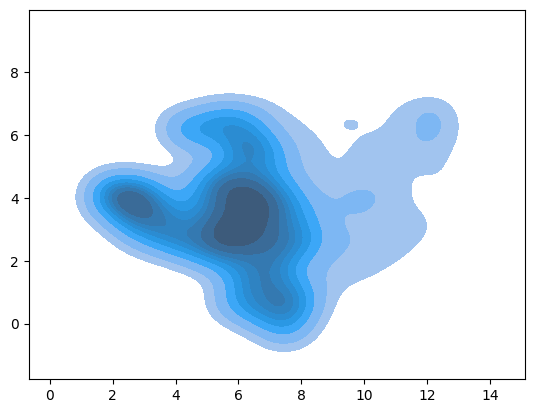

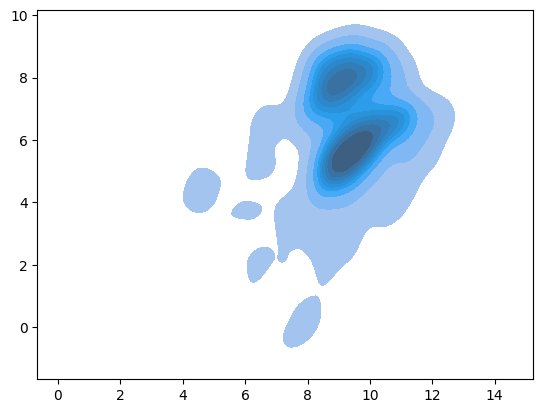

In [17]:
import seaborn as sb
for i in range(5):
    sb.kdeplot(x=emb[ids==i, 0], y=emb[ids==i, 1], fill=True, levels=10)
    plt.axis("equal")
    plt.show()
    